#1. Library imports and Data Load

In [1]:
# libraries import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
from datetime import date
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from imblearn import under_sampling
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change directory
%cd /content/drive/MyDrive/Colab Notebooks/Project Amazon Review

/content/drive/MyDrive/Colab Notebooks/Project Amazon Review


In [4]:
# open dataset
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Software.json.gz')

In [5]:
# check dataset
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4.0,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1.0,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN
3,3.0,True,"02 17, 2014",APRDVZ6QBIQXT,0077613252,{'Format:': ' Loose Leaf'},Lucy,This book was missing pages!!! Important pages...,missing pages!!,1392595200,3,NaN
4,5.0,False,"10 14, 2013",A2JZTTBSLS1QXV,0077775473,NaN,Albert V.,I have used LearnSmart and can officially say ...,Best study product out there!,1381708800,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
459431,2.0,True,"11 29, 2016",AGEWYJ2NF5C2H,B01HF41TKI,NaN,Bonita Alferes,No instructions.....No Help unless you want to...,Two Stars,1480377600,NaN,NaN
459432,1.0,True,"03 1, 2018",A3VCFV8WEQG9R5,B01HF3G4BS,NaN,mekonen,it's a joke,One Star,1519862400,NaN,NaN
459433,5.0,True,"12 2, 2017",A3DXGHJF6SOHNC,B01HF3G4BS,NaN,bbeckham,I have multiple licenses of the Antivirus. I h...,This is very effective antivirus software.,1512172800,NaN,NaN
459434,5.0,True,"09 15, 2018",A1WOS4D7QA06DO,B01HJAMWOK,NaN,Charles E. Potter,good value,Five Stars,1536969600,NaN,NaN


#2. Data Cleaning

In [ ]:
# checking null data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459436 entries, 0 to 459435
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         459436 non-null  float64
 1   verified        459436 non-null  bool   
 2   reviewTime      459436 non-null  object 
 3   reviewerID      459436 non-null  object 
 4   asin            459436 non-null  object 
 5   style           234401 non-null  object 
 6   reviewerName    459412 non-null  object 
 7   reviewText      459370 non-null  object 
 8   summary         459380 non-null  object 
 9   unixReviewTime  459436 non-null  int64  
 10  vote            127853 non-null  object 
 11  image           1508 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 42.5+ MB
None


The dtype for all data is alright, only reviewTime need to be changed into time datatype. There are some null data, but since we only use reviewText, reviewTime, and overall, only null data from reviewText will be dropped.

In [5]:
# change date data into suitable format
df['year'] = [int(x[6:11]) for x in df['reviewTime']]
df['month'] = [int(x[0:2]) for x in df['reviewTime']]
days = []
for x in df['reviewTime']:
  try:
    days.append(int(x[3:5]))
  except:
    days.append(int(x[3]))
df['day'] = days

df.to_csv('df.csv')

In [6]:
# taking date, ratings, and reviews data into new dataframe
df = pd.read_csv('df.csv',parse_dates= {"date" : ["year","month","day"]})

df_ = pd.DataFrame()
df_['date'] = df['date']
df_['rating'] = df['overall']
df_['reviews'] = df['reviewText']

In [91]:
# check new dataframe
df_

,date,rating,reviews
0,2014-03-11,4.0,The materials arrived early and were in excell...
1,2014-02-23,4.0,I am really enjoying this book with the worksh...
2,2014-02-17,1.0,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,2014-02-17,3.0,This book was missing pages!!! Important pages...
4,2013-10-14,5.0,I have used LearnSmart and can officially say ...
...,...,...,...
459431,2016-11-29,2.0,No instructions.....No Help unless you want to...
459432,2018-03-01,1.0,it's a joke
459433,2017-12-02,5.0,I have multiple licenses of the Antivirus. I h...
459434,2018-09-15,5.0,good value


In [7]:
# removes null and duplicates
df_ = df_.dropna()
df_ = df_.drop_duplicates()

In [93]:
# check new data
df_

,date,rating,reviews
0,2014-03-11,4.0,The materials arrived early and were in excell...
1,2014-02-23,4.0,I am really enjoying this book with the worksh...
2,2014-02-17,1.0,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,2014-02-17,3.0,This book was missing pages!!! Important pages...
4,2013-10-14,5.0,I have used LearnSmart and can officially say ...
...,...,...,...
459431,2016-11-29,2.0,No instructions.....No Help unless you want to...
459432,2018-03-01,1.0,it's a joke
459433,2017-12-02,5.0,I have multiple licenses of the Antivirus. I h...
459434,2018-09-15,5.0,good value


In [87]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444184 entries, 0 to 459435
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     444184 non-null  datetime64[ns]
 1   rating   444184 non-null  float64       
 2   reviews  444184 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 13.6+ MB


All the null and duplicated values are gone and all of the data is in the right type. Great! Now we will move on to the sentiment labels.

# 3. Data Pre-processing

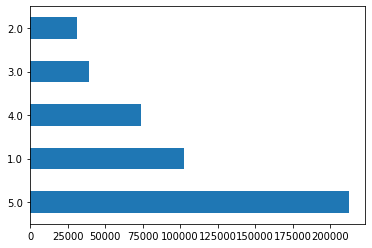

In [81]:
# checking the rating counts
df_['rating'].value_counts().plot(kind='barh')

The ratings will be divided into 3 sentiment category: Negative, Neutral, and Positive based on the ratings (rating 1-2--> negative sentiment, rating 3--> neutral sentiment, rating 4-5--> positive sentiment)

In [8]:
# make labels
def get_rating_cat(rating):
  if (rating == 1) or (rating == 2):
    return 0
  elif rating==3:
    return 1
  else:
    return 2

df_['label'] = [get_rating_cat(x) for x in df_['rating']]

In [89]:
# checking dataframe
df_

,date,rating,reviews,label
0,2014-03-11,4.0,The materials arrived early and were in excell...,2
1,2014-02-23,4.0,I am really enjoying this book with the worksh...,2
2,2014-02-17,1.0,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",0
3,2014-02-17,3.0,This book was missing pages!!! Important pages...,1
4,2013-10-14,5.0,I have used LearnSmart and can officially say ...,2
...,...,...,...,...
459431,2016-11-29,2.0,No instructions.....No Help unless you want to...,0
459432,2018-03-01,1.0,it's a joke,0
459433,2017-12-02,5.0,I have multiple licenses of the Antivirus. I h...,2
459434,2018-09-15,5.0,good value,2


In [ ]:
df_['label'].value_counts()

2    272625
0    130249
1     38178
Name: label, dtype: int64

Since the label 2 is far more than the others, the data will become imbalance. Since the data are also big enough, under sampling will be used to get balanced data.

In [9]:
# split data into X and y
X = df_[['reviews']]
y = df_[['label']]
X_under, y_under = under_sampling.RandomUnderSampler().fit_resample(X, y)

# split data into two since the data is large enough, so we can just check the suitable model before tuning
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_under,y_under, test_size=0.5, random_state=0)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=0)

In [96]:
# checking X and y train
pd.concat([X_train, y_train], axis=1)

,reviews,label
33007,"After being totally lost with ""regular"" accoun...",0
51958,It helped me figure out what I could use as de...,1
101158,GUEST REVIEWER - ! MRS. KNOW IT ALL ;-b\n\nHav...,2
71866,I bought this old version because I have a som...,1
88491,I don't know why everyone is butt hurt about w...,2
...,...,...
9912,Won't allow me to open or read books I have do...,0
106558,I have been using this for years. It dose not ...,2
66818,"For 15 years I used TT Deluxe, and it was fine...",1
60012,"Forced to upgrade, again, or lose download cap...",1


In [10]:
# using vectorizer to transform text data into feature index in the matrix
tfid_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                  stop_words='english', 
                                  token_pattern="\\b[a-z][a-z]+\\b",
                                  lowercase=True,
                                  max_df = 0.5,
                                  max_features=10000)

# fit transform train data and transform test data
tfid_train = tfid_vectorizer.fit_transform(X_train.reviews.values.tolist())
tfid_test = tfid_vectorizer.transform(X_test.reviews.values.tolist())

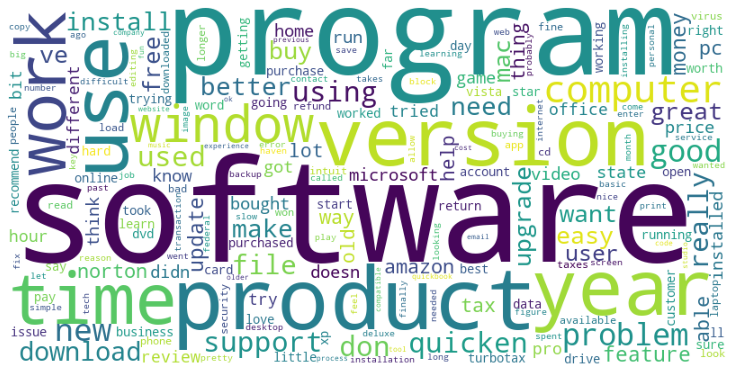

In [ ]:
# data visualization using wordcloud
words = tfid_vectorizer.get_feature_names()
for_wordcloud_str = ' '.join(words)

wordcloud = WordCloud(width=800, height=400, background_color ='white',
                      min_font_size = 7).generate(for_wordcloud_str)

plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
 
plt.show()

This is the data that we are working with. Seems legit considering the database is about the software reviews and most of the texts are related to technology.

# 4. Data Modelling

In [ ]:
# first model trial: decision tree
model = DecisionTreeClassifier()
start = time()
model.fit(tfid_train, y_train)
train_time = time() - start
start = time()
y_pred = model.predict(tfid_test.toarray())
predict_time = time()-start    
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tAccuracy:", accuracy_score(y_test, y_pred))

DecisionTreeClassifier()
	Training time: 52.932s
	Prediction time: 0.959s
	Accuracy: 0.5473390303748202


In [ ]:
# second model trial: random forest
model2 = RandomForestClassifier()
start = time()
model2.fit(tfid_train, y_train)
train_time = time() - start
start = time()
y_pred2 = model.predict(tfid_test.toarray())
predict_time = time()-start    
print(model2)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tAccuracy:", accuracy_score(y_test, y_pred2))

RandomForestClassifier()
	Training time: 219.038s
	Prediction time: 0.577s
	Accuracy: 0.5473390303748202


In [ ]:
# third model trial: logistic regression
model3 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
start = time()
model3.fit(tfid_train, y_train)
train_time = time() - start
start = time()
y_pred3 = model3.predict(tfid_test)
predict_time = time()-start    
print(model3)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tAccuracy:", accuracy_score(y_test, y_pred3))

LogisticRegression(multi_class='multinomial')
	Training time: 6.370s
	Prediction time: 0.005s
	Accuracy: 0.6926981978170742


Since logistic regression is the best model for these data, it will be tuned to the best hyperparameter.

In [14]:
# tuning penalty and c_values
model_log = LogisticRegression(multi_class='multinomial')
solvers = ['lbfgs']
penalty = ['none','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model_log, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(tfid_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.684566 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.644553 (0.010609) with: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'}
0.647328 (0.010329) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.644553 (0.010609) with: {'C': 10, 'penalty': 'none', 'solver': 'lbfgs'}
0.662983 (0.009766) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.644553 (0.010609) with: {'C': 1.0, 'penalty': 'none', 'solver': 'lbfgs'}
0.684566 (0.010189) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.644553 (0.010609) with: {'C': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}
0.675515 (0.009708) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.644553 (0.010609) with: {'C': 0.01, 'penalty': 'none', 'solver': 'lbfgs'}
0.642955 (0.010577) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
model_final = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1)
model_final.fit(tfid_train, y_train)
y_pred_final = model_final.predict(tfid_test)
print(model_final)
print("\tAccuracy:", accuracy_score(y_test, y_pred_final))

LogisticRegression(C=1, multi_class='multinomial')
	Accuracy: 0.6926981978170742


Taking the best parameters into the logistic model will get the exact same accuracy, since the best parameters turn out to be the default parameter. Now we will use all the data to get the better trained model.

In [ ]:
# split all undersampled data into train and test, then vectorized them
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size=0.2, random_state=0)
tfid_train = tfid_vectorizer.fit_transform(X_train.reviews.values.tolist())
tfid_test = tfid_vectorizer.transform(X_test.reviews.values.tolist())

# fit into the best model we got
model_final = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1)
model_final.fit(tfid_train, y_train)
y_pred_final = model_final.predict(tfid_test)
#summarize results
print(model_final)
print("\tAccuracy:", accuracy_score(y_test, y_pred_final))

LogisticRegression(C=1, multi_class='multinomial')
	Accuracy: 0.6968312391589457


In [ ]:
# testing out the model
test_text = ['It is alright','I hate it','Oh it was a wonderful experience!']
prediction = model_final.predict_proba(tfid_vectorizer.transform(test_text))

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

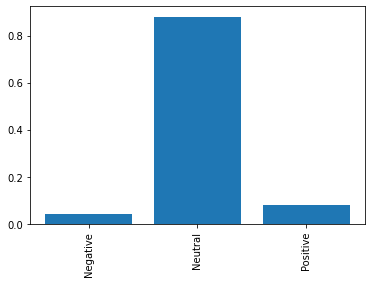

In [ ]:
# visualize results
x_label = ['Negative', 'Neutral', 'Positive']
y_label = prediction[0]

plt.bar(x_label, height = y_label)
plt.xticks(rotation=90)

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

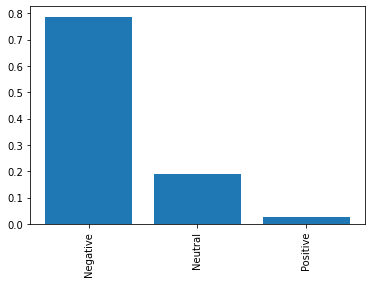

In [ ]:
# visualize results (2)
x_label = ['Negative', 'Neutral', 'Positive']
y_label = prediction[1]

plt.bar(x_label, height = y_label)
plt.xticks(rotation=90)

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

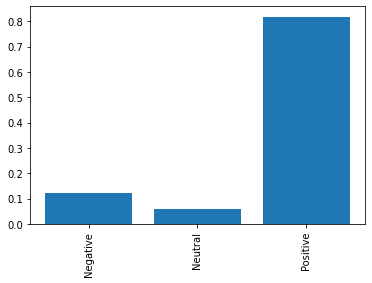

In [ ]:
# visualize results (3)
x_label = ['Negative', 'Neutral', 'Positive']
y_label = prediction[2]

plt.bar(x_label, height = y_label)
plt.xticks(rotation=90)

The models work well. Now we only need to deploy

# 5. Model saving

In [ ]:
# save the model with pickle library
data = {'model': model_final,'tfid_vectorizer': tfid_vectorizer}
with open('saved_model.pkl','wb') as file:
  pickle.dump(data, file)

# 6. Model usage example

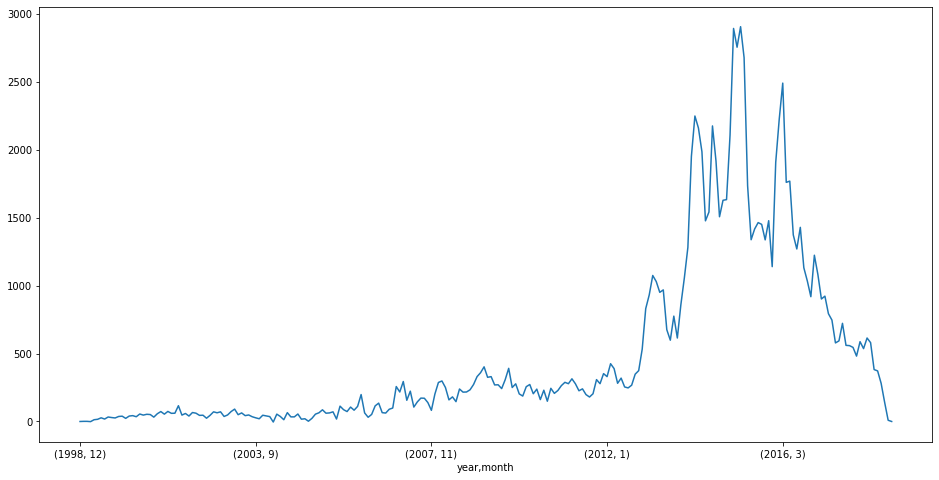

In [ ]:
# labeling sentiment_score based on the model, then get the sentiment score per month
def get_sentiment_score(review):
  if int(model_final.predict(tfid_vectorizer.transform([review]))) == 0:
    return -1
  elif int(model_final.predict(tfid_vectorizer.transform([review]))) == 1:
    return 0
  else:
    return 1

df_['sentiment_score'] = [get_sentiment_score(review) for review in df_['reviews']]
df_example = df_[['date', 'sentiment_score']].sort_values(by=['date'])
df_example['year'] = pd.DatetimeIndex(df_['date']).year
df_example['month'] = pd.DatetimeIndex(df_['date']).month
df_example = df_example.groupby(['year','month'])['sentiment_score'].sum()

df_example.plot(label='df_final',figsize=(16, 8))

In [ ]:
df_example.to_csv('df_final')